##Информация из оригинальной статьи

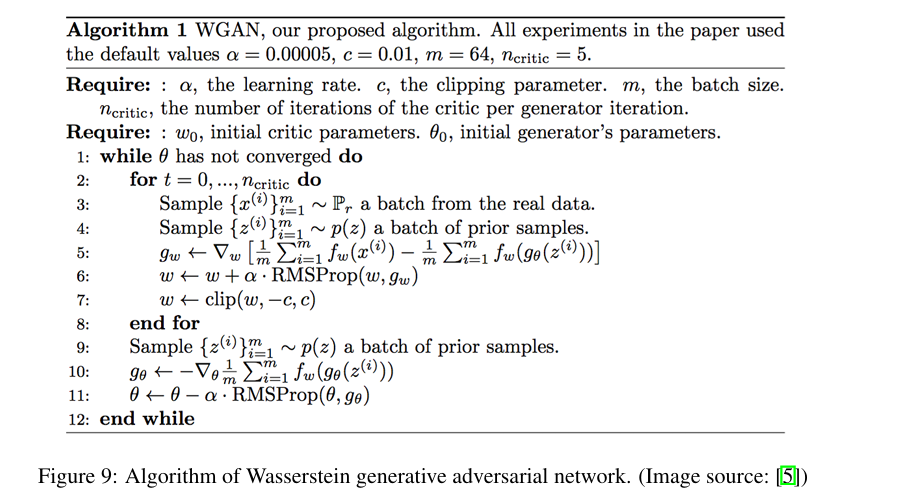

## Сравнение WGAN с оригинальным GAN

По сравнению с оригинальным алгоритмом GAN, WGAN вносит следующие изменения:

### 1. Weight Clipping (Ограничение весов)
После каждого обновления градиента для функции критика (critic), веса ограничиваются до небольшого фиксированного диапазона:  
**[-c, c]**

### 2. Новая функция потерь
Используется новая функция потерь, выведенная из расстояния Вассерштейна, без логарифмов.

### 3. Роль дискриминатора
Модель "дискриминатора" выступает не как прямой критик, а как помощник для оценки метрики Вассерштейна между распределениями реальных и сгенерированных данных.

### 4. Оптимизатор
Эмпирически авторы рекомендуют использовать оптимизатор **RMSProp** для критика, а не оптимизаторы на основе момента, такие как Adam, которые могут вызвать нестабильность при обучении модели. *Четкого теоретического объяснения этого момента я не видел.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np

from torch.autograd import Variable

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

config.n_critic = 5
config.clip_value = 0.01
config.num_classes = 10 # для условной генерации
config.embedding_dim = 10
config.lambda_gp = 10


In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]


In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([16, 1, 28, 28])

In [ ]:
28*28

784

<H1>1) Модифицируйте код и реализуйте Wasserstein GAN (From GAN to WGAN ) используя weight clipping.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 784),
            nn.Tanh()
            )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

#criterion = nn.BCELoss()
losses_D_clip = []
losses_G_clip = []
iters = 0

fixed_noise = torch.randn(16, config.noise_size)

In [ ]:
for epoch in range(config.num_epochs):
    for batch_idx, (real_images, _) in enumerate(dataloader):

        batch_size = real_images.shape[0]

        # Обучение Критика
        for _ in range(config.n_critic):
            noise = torch.randn(batch_size, config.noise_size)
            fake_images = generator(noise).detach()

            critic_real = discriminator(real_images)
            critic_fake = discriminator(fake_images)


            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optim_D.zero_grad()
            loss_critic.backward()
            optim_D.step()


            for p in discriminator.parameters():
                p.data.clamp_(-config.clip_value, config.clip_value)

        # Обучение Генератора

        noise = torch.randn(batch_size, config.noise_size)
        fake_images = generator(noise)
        critic_fake = discriminator(fake_images)

        loss_gen = -torch.mean(critic_fake)

        optim_G.zero_grad()
        loss_gen.backward()
        optim_G.step()

        losses_D_clip.append(loss_critic.item())
        losses_G_clip.append(loss_gen.item())
        iters += 1
        if (batch_idx + 1) % config.print_freq == 0:
          print('Epoch:{} Iter: {} Loss D: {:.4f} Loss G: {:.4f}'.format(epoch,
                                                                  batch_idx + 1,
                                                                  loss_critic.item(),
                                                                  loss_gen.item()))

    print(f"Epoch [{epoch}/{config.num_epochs}] Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")

Epoch:0 Iter: 100 Loss D: -6.9103 Loss G: -1.2755
Epoch:0 Iter: 200 Loss D: -4.3928 Loss G: -0.9353
Epoch:0 Iter: 300 Loss D: -5.2322 Loss G: -0.2141
Epoch:0 Iter: 400 Loss D: -4.0374 Loss G: -0.3225
Epoch:0 Iter: 500 Loss D: -4.5935 Loss G: -2.0775
Epoch:0 Iter: 600 Loss D: -2.9089 Loss G: -0.6990
Epoch:0 Iter: 700 Loss D: -2.2440 Loss G: -1.8055
Epoch:0 Iter: 800 Loss D: -2.0203 Loss G: -1.2277
Epoch:0 Iter: 900 Loss D: -2.0709 Loss G: -1.3108
Epoch:0 Iter: 1000 Loss D: -0.7588 Loss G: -0.8313
Epoch:0 Iter: 1100 Loss D: -1.1067 Loss G: -1.2872
Epoch:0 Iter: 1200 Loss D: -0.4038 Loss G: -1.1510
Epoch:0 Iter: 1300 Loss D: -0.5477 Loss G: -1.7122
Epoch:0 Iter: 1400 Loss D: -0.6165 Loss G: -0.9228
Epoch:0 Iter: 1500 Loss D: -0.2477 Loss G: -0.5414
Epoch:0 Iter: 1600 Loss D: -0.1769 Loss G: -0.0252
Epoch:0 Iter: 1700 Loss D: -0.2300 Loss G: -0.6667
Epoch:0 Iter: 1800 Loss D: -0.3452 Loss G: -0.1748
Epoch:0 Iter: 1900 Loss D: -0.1004 Loss G: 0.5415
Epoch:0 Iter: 2000 Loss D: -0.3623 Loss G

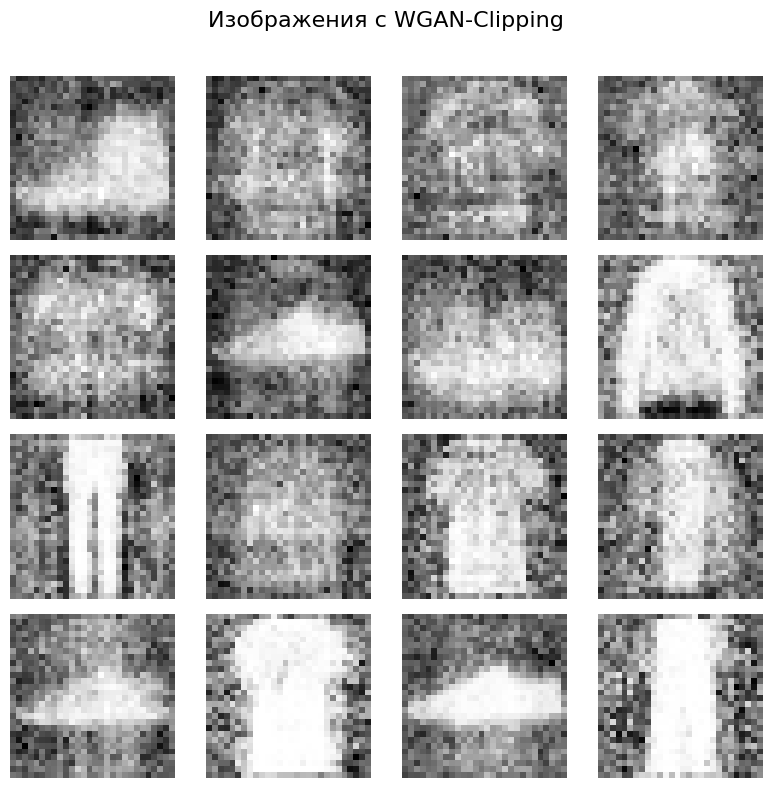

In [ ]:
generator.eval()
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()


fake = (fake + 1) / 2

plt.figure(figsize=(8, 8))
plt.suptitle(f"Изображения с WGAN-Clipping", fontsize=16)

for i in range(16):
    plt.subplot(4, 4, i + 1)

    img = fake[i].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 2) Замените weight clipping на gradient penalty.

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, lambda_gp=10):
    """
    Рассчитывает Gradient Penalty (GP) между реальными и сгенерированными сэмплами.
    """
    batch_size = real_samples.size(0)


    alpha = torch.rand(batch_size, 1).expand_as(real_samples.view(batch_size, -1))

    real_samples_flat = real_samples.view(batch_size, -1)
    fake_samples_flat = fake_samples.view(batch_size, -1)


    interpolates = (alpha * real_samples_flat + ((1 - alpha) * fake_samples_flat)).requires_grad_(True)


    d_interpolates = discriminator(interpolates)


    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]


    gradients = gradients.view(batch_size, -1)
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [ ]:
lambda_gp = 10
lr_gp = 1e-4

optim_G = optim.Adam(generator.parameters(), lr=lr_gp, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=lr_gp, betas=(0.5, 0.999))

losses_D_gp = []
losses_G_gp = []
iters = 0

fixed_noise = torch.randn(16, config.noise_size)


for epoch in range(config.num_epochs):
    for batch_idx, (real_images, _) in enumerate(dataloader):

        batch_size = real_images.shape[0]

        # Обучение Критика
        for _ in range(config.n_critic):
            optim_D.zero_grad()


            noise = torch.randn(batch_size, config.noise_size)
            fake_images = generator(noise).detach()

            critic_real = discriminator(real_images)
            critic_fake = discriminator(fake_images)


            gp = compute_gradient_penalty(discriminator, real_images, fake_images)


            loss_wasserstein = torch.mean(critic_fake) - torch.mean(critic_real)


            loss_critic = loss_wasserstein + gp

            loss_critic.backward()
            optim_D.step()



        # Обучение Генератора
        optim_G.zero_grad()

        noise = torch.randn(batch_size, config.noise_size)
        fake_images = generator(noise)
        critic_fake = discriminator(fake_images)


        loss_gen = -torch.mean(critic_fake)

        loss_gen.backward()
        optim_G.step()

        losses_D_gp.append(loss_critic.item())
        losses_G_gp.append(loss_gen.item())
        iters += 1

        if (batch_idx + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} Loss D: {:.4f} Loss G: {:.4f}'.format(epoch,
                                                                          batch_idx + 1,
                                                                          loss_critic.item(),
                                                                          loss_gen.item()))
    print(f"Epoch [{epoch}/{config.num_epochs}] Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")

Epoch:0 Iter: 100 Loss D: 1.5338 Loss G: 2.5349
Epoch:0 Iter: 200 Loss D: 0.4617 Loss G: 2.4209
Epoch:0 Iter: 300 Loss D: 0.0735 Loss G: 2.7970
Epoch:0 Iter: 400 Loss D: -0.7365 Loss G: 4.4825
Epoch:0 Iter: 500 Loss D: -1.6025 Loss G: 2.6833
Epoch:0 Iter: 600 Loss D: -1.5414 Loss G: 9.8705
Epoch:0 Iter: 700 Loss D: 4.5709 Loss G: 0.2138
Epoch:0 Iter: 800 Loss D: -2.3352 Loss G: 10.4368
Epoch:0 Iter: 900 Loss D: -0.8445 Loss G: -0.4672
Epoch:0 Iter: 1000 Loss D: -1.5152 Loss G: 4.9550
Epoch:0 Iter: 1100 Loss D: -0.4485 Loss G: 2.5047
Epoch:0 Iter: 1200 Loss D: -1.9631 Loss G: 6.4443
Epoch:0 Iter: 1300 Loss D: -1.7370 Loss G: 6.0458
Epoch:0 Iter: 1400 Loss D: -1.5425 Loss G: 9.7719
Epoch:0 Iter: 1500 Loss D: -1.9596 Loss G: -3.4214
Epoch:0 Iter: 1600 Loss D: -0.7567 Loss G: 5.0346
Epoch:0 Iter: 1700 Loss D: -0.3938 Loss G: 6.1366
Epoch:0 Iter: 1800 Loss D: -1.1485 Loss G: 3.2304
Epoch:0 Iter: 1900 Loss D: -0.7295 Loss G: 3.0565
Epoch:0 Iter: 2000 Loss D: -0.3458 Loss G: -5.4829
Epoch:0 I

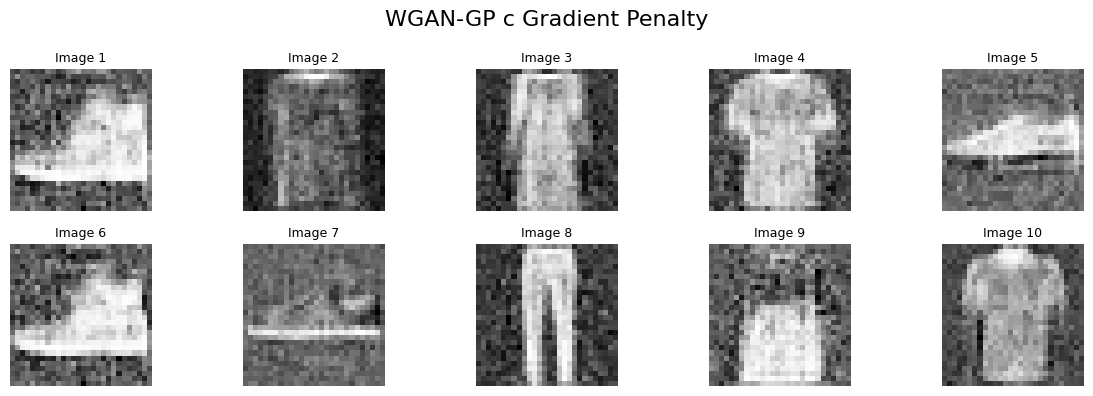

In [29]:


num_classes = 10
noise_size = 50

generator.eval()
with torch.no_grad():
    fixed_noise = torch.randn(num_classes, noise_size)


    fake = generator(fixed_noise).detach().cpu()

    fake = (fake + 1) / 2

# Визуализация
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

plt.figure(figsize=(12, 4))
plt.suptitle("WGAN-GP с Gradient Penalty", fontsize=16)

for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    img = fake[i].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i+1}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3) Условная генерация

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=50, num_classes=10, embedding_dim=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, embedding_dim)


        self.model = nn.Sequential(
            nn.Linear(noise_dim + embedding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels)
        combined = torch.cat([z, label_embed], dim=1)
        return self.model(combined)

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, embedding_dim=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, embedding_dim)


        self.model = nn.Sequential(
            nn.Linear(784 + embedding_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x, labels):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        label_embed = self.label_embedding(labels)
        combined = torch.cat([x, label_embed], dim=1)
        return self.model(combined)

In [ ]:
def compute_conditional_gradient_penalty(discriminator, real_samples, fake_samples, labels):
    batch_size = real_samples.size(0)


    if real_samples.dim() > 2:
        real_samples = real_samples.view(batch_size, -1)
        fake_samples = fake_samples.view(batch_size, -1)

    alpha = torch.rand(batch_size, 1, device=real_samples.device)
    alpha = alpha.expand_as(real_samples)

    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates = interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates, labels)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    return gradient_penalty

In [ ]:
def train_conditional_wgan():
    print("CONDITIONAL WGAN")


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    generator = ConditionalGenerator(
        noise_dim=config.noise_size,
        num_classes=config.num_classes,
        embedding_dim=config.embedding_dim
    ).to(device)

    discriminator = ConditionalDiscriminator(
        num_classes=config.num_classes,
        embedding_dim=config.embedding_dim
    ).to(device)


    lr = 1e-4
    optim_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
    optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))


    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = datasets.FashionMNIST(
        "fashion_mnist",
        train=True,
        transform=transform,
        download=True
    )

    dataloader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,  # 16!
        shuffle=True,
        num_workers=config.num_workers
    )

    G_losses = []
    D_losses = []

    for epoch in range(config.num_epochs):
        for batch_idx, (real_images, real_labels) in enumerate(dataloader):
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            batch_size = real_images.size(0)


            for _ in range(config.n_critic):
                optim_D.zero_grad()


                noise = torch.randn(batch_size, config.noise_size, device=device)
                fake_labels = torch.randint(0, config.num_classes, (batch_size,), device=device)
                fake_images = generator(noise, fake_labels)


                critic_real = discriminator(real_images, real_labels)
                critic_fake = discriminator(fake_images.detach(), fake_labels)


                loss_w = torch.mean(critic_fake) - torch.mean(critic_real)


                gp = compute_conditional_gradient_penalty(
                    discriminator, real_images, fake_images, fake_labels
                )

                loss_D = loss_w + config.lambda_gp * gp
                loss_D.backward()
                optim_D.step()


            optim_G.zero_grad()

            noise = torch.randn(batch_size, config.noise_size, device=device)
            fake_images = generator(noise, fake_labels)
            critic_fake = discriminator(fake_images, fake_labels)

            loss_G = -torch.mean(critic_fake)
            loss_G.backward()
            optim_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            if (batch_idx + 1) % config.print_freq == 0:
                print(f'Epoch [{epoch+1}/{config.num_epochs}] '
                      f'Batch [{batch_idx+1}/{len(dataloader)}] '
                      f'Loss D: {loss_D.item():.4f} '
                      f'Loss G: {loss_G.item():.4f}')


        if (epoch + 1) % 2 == 0:
            generator.eval()
            with torch.no_grad():

                noise = torch.randn(config.num_classes, config.noise_size, device=device)
                labels = torch.arange(config.num_classes, device=device)

                generated = generator(noise, labels).cpu()
                generated = generated * 0.5 + 0.5

                plt.figure(figsize=(12, 4))
                plt.suptitle(f'Conditional WGAN-GP - Epoch {epoch+1}', fontsize=16)

                for i in range(config.num_classes):
                    plt.subplot(2, 5, i + 1)
                    plt.imshow(generated[i].view(28, 28).numpy(), cmap='gray')
                    plt.title(f'{i}: {class_names[i]}', fontsize=8)
                    plt.axis('off')

                plt.tight_layout()
                plt.show()
            generator.train()

        print(f'Epoch [{epoch+1}/{config.num_epochs}] завершена')

    return generator, discriminator, G_losses, D_losses

CONDITIONAL WGAN


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10] Batch [100/3750] Loss D: -21.0852 Loss G: 2.6454
Epoch [1/10] Batch [200/3750] Loss D: -23.5519 Loss G: 3.6820
Epoch [1/10] Batch [300/3750] Loss D: -22.6572 Loss G: 7.2945
Epoch [1/10] Batch [400/3750] Loss D: -15.5730 Loss G: 5.6078
Epoch [1/10] Batch [500/3750] Loss D: -13.4987 Loss G: 0.3274
Epoch [1/10] Batch [600/3750] Loss D: -10.2498 Loss G: 14.5108
Epoch [1/10] Batch [700/3750] Loss D: -9.8796 Loss G: 19.0507
Epoch [1/10] Batch [800/3750] Loss D: -10.8394 Loss G: 13.4594
Epoch [1/10] Batch [900/3750] Loss D: -8.4198 Loss G: 13.6657
Epoch [1/10] Batch [1000/3750] Loss D: -9.6151 Loss G: 13.5836
Epoch [1/10] Batch [1100/3750] Loss D: -11.1428 Loss G: 1.8099
Epoch [1/10] Batch [1200/3750] Loss D: -8.1174 Loss G: -2.5331
Epoch [1/10] Batch [1300/3750] Loss D: -7.4830 Loss G: 1.4530
Epoch [1/10] Batch [1400/3750] Loss D: -6.6885 Loss G: -3.5631
Epoch [1/10] Batch [1500/3750] Loss D: -6.3434 Loss G: -8.7145
Epoch [1/10] Batch [1600/3750] Loss D: -1.2025 Loss G: 7.1922
E

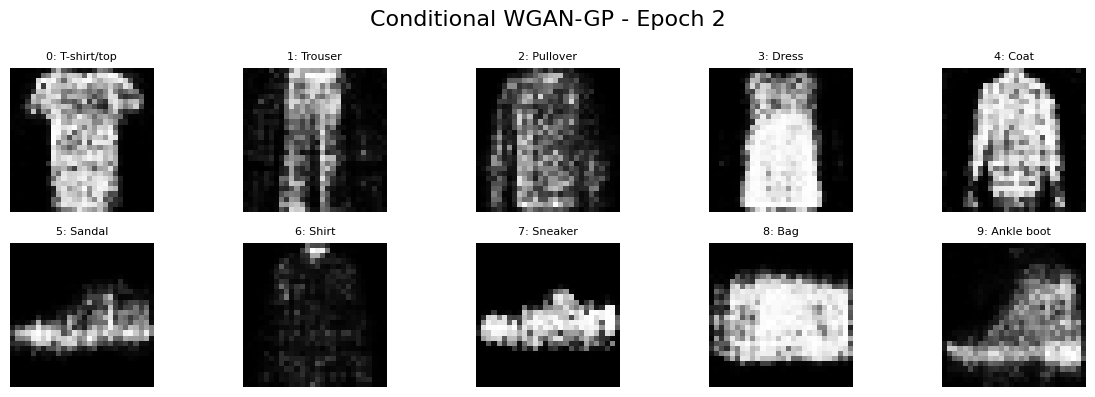

Epoch [2/10] завершена
Epoch [3/10] Batch [100/3750] Loss D: -4.2652 Loss G: -6.7091
Epoch [3/10] Batch [200/3750] Loss D: -3.4036 Loss G: -7.2618
Epoch [3/10] Batch [300/3750] Loss D: -3.1206 Loss G: -0.0281
Epoch [3/10] Batch [400/3750] Loss D: -1.7657 Loss G: -6.4999
Epoch [3/10] Batch [500/3750] Loss D: -3.6210 Loss G: -5.1874
Epoch [3/10] Batch [600/3750] Loss D: -2.3221 Loss G: -7.3378
Epoch [3/10] Batch [700/3750] Loss D: -1.4933 Loss G: 5.9019
Epoch [3/10] Batch [800/3750] Loss D: -0.7629 Loss G: -5.5040
Epoch [3/10] Batch [900/3750] Loss D: -6.9085 Loss G: 5.1497
Epoch [3/10] Batch [1000/3750] Loss D: -3.5852 Loss G: -3.8598
Epoch [3/10] Batch [1100/3750] Loss D: -0.1128 Loss G: 5.1618
Epoch [3/10] Batch [1200/3750] Loss D: -2.2513 Loss G: -12.1619
Epoch [3/10] Batch [1300/3750] Loss D: -0.3289 Loss G: -9.5115
Epoch [3/10] Batch [1400/3750] Loss D: -1.9087 Loss G: -8.9554
Epoch [3/10] Batch [1500/3750] Loss D: -0.9715 Loss G: 4.6892
Epoch [3/10] Batch [1600/3750] Loss D: -1.63

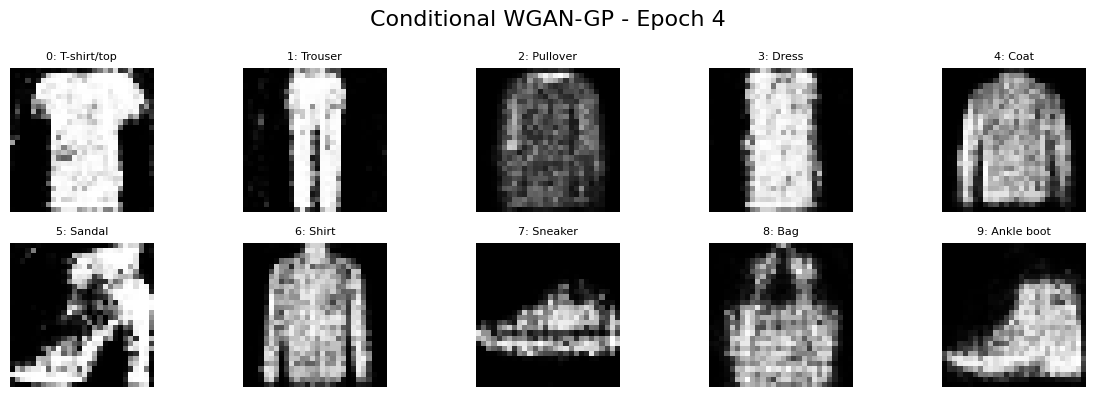

Epoch [4/10] завершена
Epoch [5/10] Batch [100/3750] Loss D: -0.4199 Loss G: -7.5803
Epoch [5/10] Batch [200/3750] Loss D: -5.1992 Loss G: -6.8033
Epoch [5/10] Batch [300/3750] Loss D: -6.3371 Loss G: -7.2286
Epoch [5/10] Batch [400/3750] Loss D: -4.7559 Loss G: -15.7654
Epoch [5/10] Batch [500/3750] Loss D: 0.3563 Loss G: -3.2460
Epoch [5/10] Batch [600/3750] Loss D: -3.3495 Loss G: -14.1203
Epoch [5/10] Batch [700/3750] Loss D: -4.6453 Loss G: 3.4124
Epoch [5/10] Batch [800/3750] Loss D: 3.4559 Loss G: -19.1852
Epoch [5/10] Batch [900/3750] Loss D: 0.0607 Loss G: 0.7951
Epoch [5/10] Batch [1000/3750] Loss D: -0.1509 Loss G: -14.0415
Epoch [5/10] Batch [1100/3750] Loss D: -6.9134 Loss G: -9.3317
Epoch [5/10] Batch [1200/3750] Loss D: -3.7327 Loss G: 8.2033
Epoch [5/10] Batch [1300/3750] Loss D: -3.0832 Loss G: 11.0629
Epoch [5/10] Batch [1400/3750] Loss D: -3.3913 Loss G: 2.7839
Epoch [5/10] Batch [1500/3750] Loss D: -0.9326 Loss G: -9.7253
Epoch [5/10] Batch [1600/3750] Loss D: -1.89

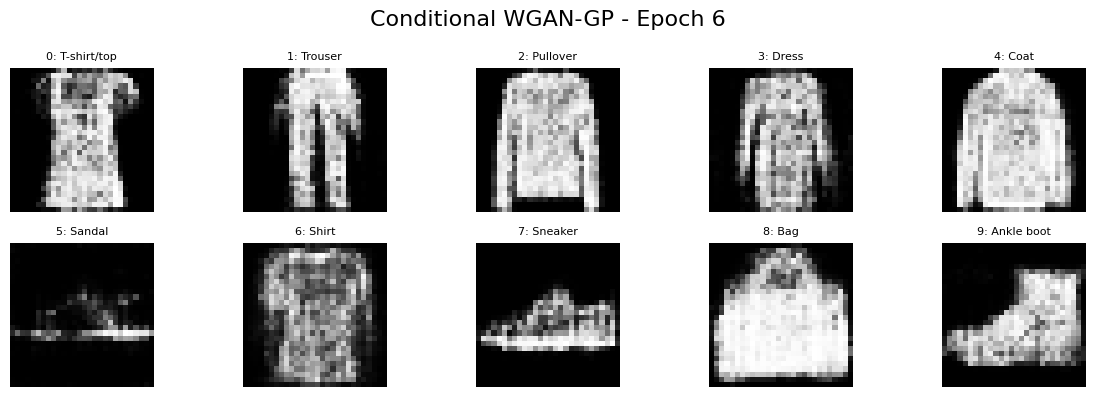

Epoch [6/10] завершена
Epoch [7/10] Batch [100/3750] Loss D: -0.1260 Loss G: -3.0171
Epoch [7/10] Batch [200/3750] Loss D: -2.3372 Loss G: -1.7464
Epoch [7/10] Batch [300/3750] Loss D: -1.5325 Loss G: -5.8437
Epoch [7/10] Batch [400/3750] Loss D: -1.6580 Loss G: -5.3988
Epoch [7/10] Batch [500/3750] Loss D: -2.7785 Loss G: -2.8721
Epoch [7/10] Batch [600/3750] Loss D: -0.3765 Loss G: 1.6812
Epoch [7/10] Batch [700/3750] Loss D: -0.0877 Loss G: -1.4367
Epoch [7/10] Batch [800/3750] Loss D: -1.3648 Loss G: -8.1968
Epoch [7/10] Batch [900/3750] Loss D: 1.0610 Loss G: -2.6609
Epoch [7/10] Batch [1000/3750] Loss D: -0.8635 Loss G: -4.7001
Epoch [7/10] Batch [1100/3750] Loss D: 2.5092 Loss G: 2.9170
Epoch [7/10] Batch [1200/3750] Loss D: -3.0040 Loss G: 2.5397
Epoch [7/10] Batch [1300/3750] Loss D: -2.4379 Loss G: -0.7455
Epoch [7/10] Batch [1400/3750] Loss D: 2.0803 Loss G: 12.8314
Epoch [7/10] Batch [1500/3750] Loss D: -3.6877 Loss G: -5.0381
Epoch [7/10] Batch [1600/3750] Loss D: -2.1972 

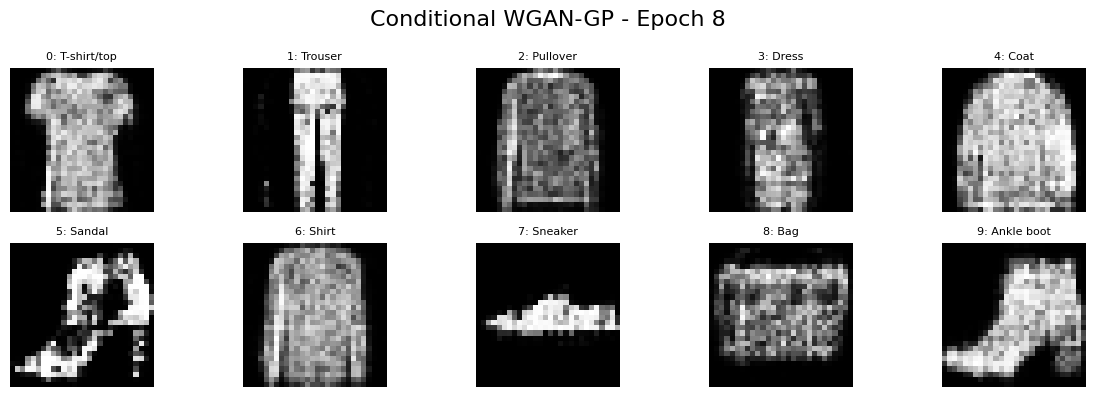

Epoch [8/10] завершена
Epoch [9/10] Batch [100/3750] Loss D: -2.4768 Loss G: -3.6980
Epoch [9/10] Batch [200/3750] Loss D: -4.2037 Loss G: -5.4002
Epoch [9/10] Batch [300/3750] Loss D: -1.0364 Loss G: -15.9716
Epoch [9/10] Batch [400/3750] Loss D: 1.3870 Loss G: -10.6250
Epoch [9/10] Batch [500/3750] Loss D: -1.0598 Loss G: -7.1127
Epoch [9/10] Batch [600/3750] Loss D: -1.6796 Loss G: -11.1100
Epoch [9/10] Batch [700/3750] Loss D: -7.4109 Loss G: -8.6824
Epoch [9/10] Batch [800/3750] Loss D: -2.1984 Loss G: -14.2130
Epoch [9/10] Batch [900/3750] Loss D: -1.8535 Loss G: -5.4919
Epoch [9/10] Batch [1000/3750] Loss D: -3.6862 Loss G: -9.3673
Epoch [9/10] Batch [1100/3750] Loss D: -0.3921 Loss G: -3.0670
Epoch [9/10] Batch [1200/3750] Loss D: -2.2209 Loss G: 14.0160
Epoch [9/10] Batch [1300/3750] Loss D: -3.0000 Loss G: -8.6948
Epoch [9/10] Batch [1400/3750] Loss D: -3.8646 Loss G: -2.8509
Epoch [9/10] Batch [1500/3750] Loss D: 0.2623 Loss G: 5.6343
Epoch [9/10] Batch [1600/3750] Loss D: -

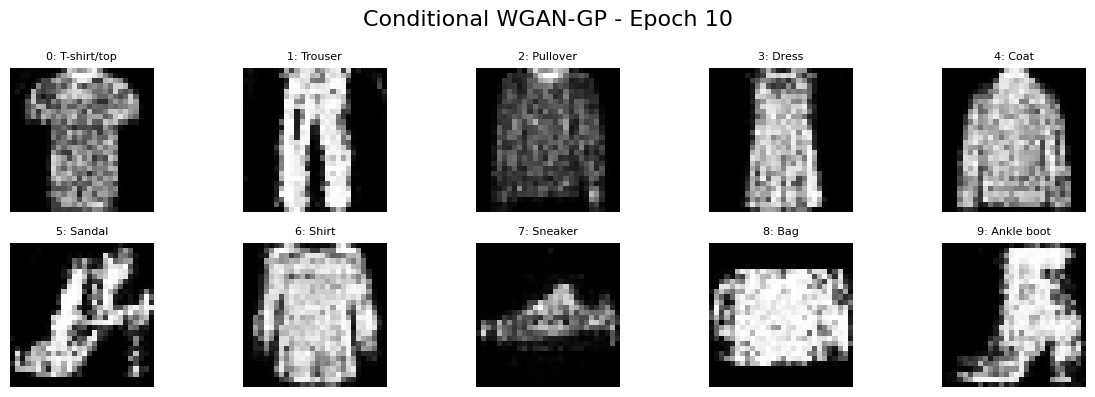

Epoch [10/10] завершена


In [25]:
gen_cond, critic_cond, losses_G_cond, losses_D_cond = train_conditional_wgan()


In [26]:
def final_demo(generator, device):

    generator.eval()

    with torch.no_grad():

        noise = torch.randn(config.num_classes, config.noise_size, device=device)
        labels = torch.arange(config.num_classes, device=device)

        generated_all = generator(noise, labels).cpu()
        generated_all = generated_all * 0.5 + 0.5

        plt.figure(figsize=(12, 4))
        for i in range(config.num_classes):
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_all[i].view(28, 28).numpy(), cmap='gray')
            plt.title(f'Class {i}: {class_names[i]}', fontsize=8)
            plt.axis('off')
        plt.suptitle('Conditional WGAN-GP: Все классы FashionMNIST')
        plt.tight_layout()
        plt.show()


        target_class = 3
        num_examples = 8
        noise_many = torch.randn(num_examples, config.noise_size, device=device)
        labels_many = torch.full((num_examples,), target_class, device=device)

        generated_many = generator(noise_many, labels_many).cpu()
        generated_many = generated_many * 0.5 + 0.5

        plt.figure(figsize=(10, 3))
        for i in range(num_examples):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(generated_many[i].view(28, 28).numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Класс {target_class}: {class_names[target_class]} (8 разных примеров)')
        plt.tight_layout()
        plt.show()

        # 3. Один шум + разные классы
        same_noise = torch.randn(1, config.noise_size, device=device).repeat(config.num_classes, 1)
        generated_matrix = generator(same_noise, labels).cpu()
        generated_matrix = generated_matrix * 0.5 + 0.5

        plt.figure(figsize=(12, 4))
        for i in range(config.num_classes):
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_matrix[i].view(28, 28).numpy(), cmap='gray')
            plt.title(f'Class {i} with same noise', fontsize=8)
            plt.axis('off')
        plt.suptitle('Один шум + разные метки = разные изображения')
        plt.tight_layout()
        plt.show()

    generator.train()


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

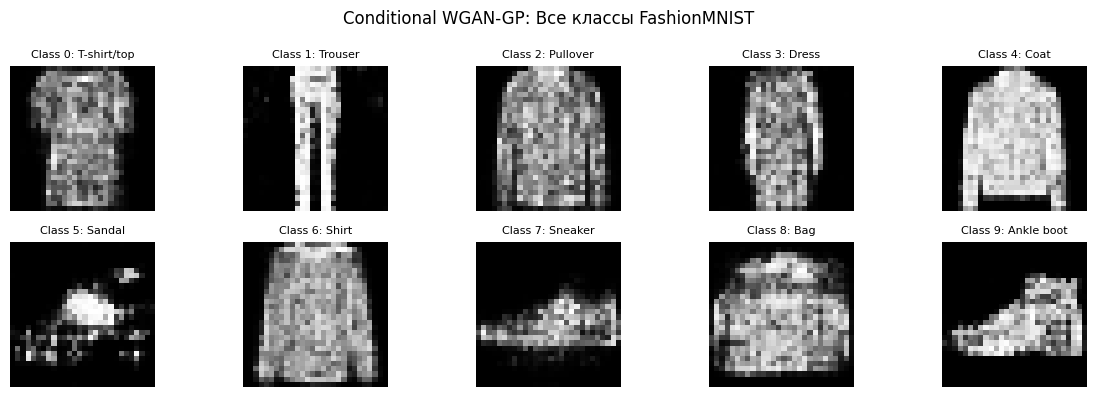

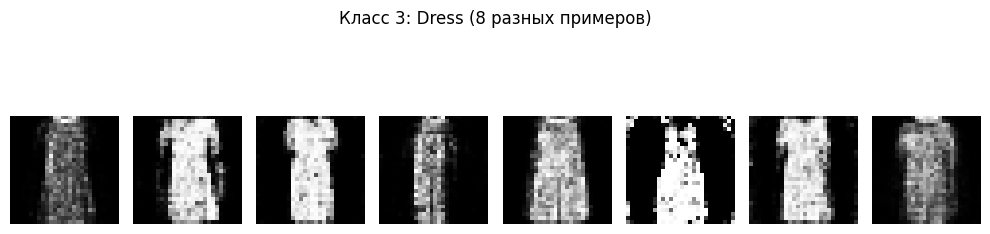

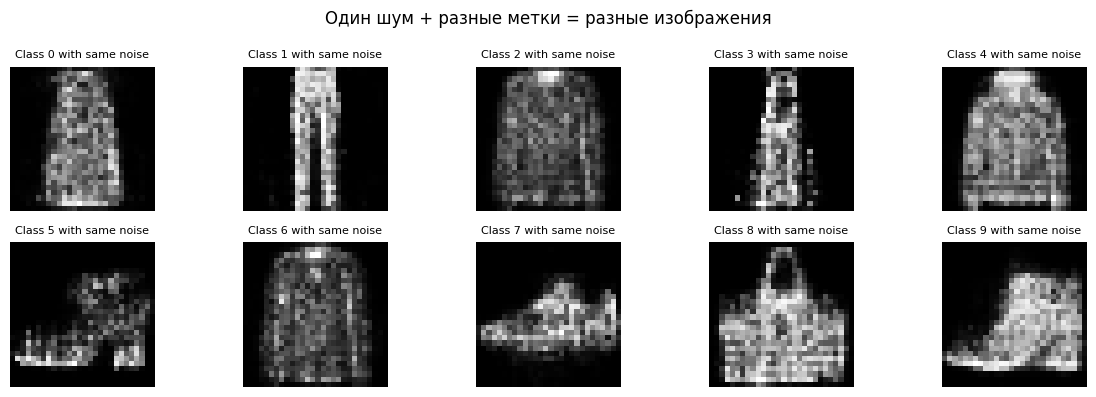

In [28]:
final_demo(gen_cond, device)

## Сравнения результатов и пути улучшения

WGAN с Weight Clipping: 37500 итераций
WGAN-GP: 37500 итераций
Conditional WGAN-GP: 37500 итераций
Всего экспериментов: 3
Графики обучения


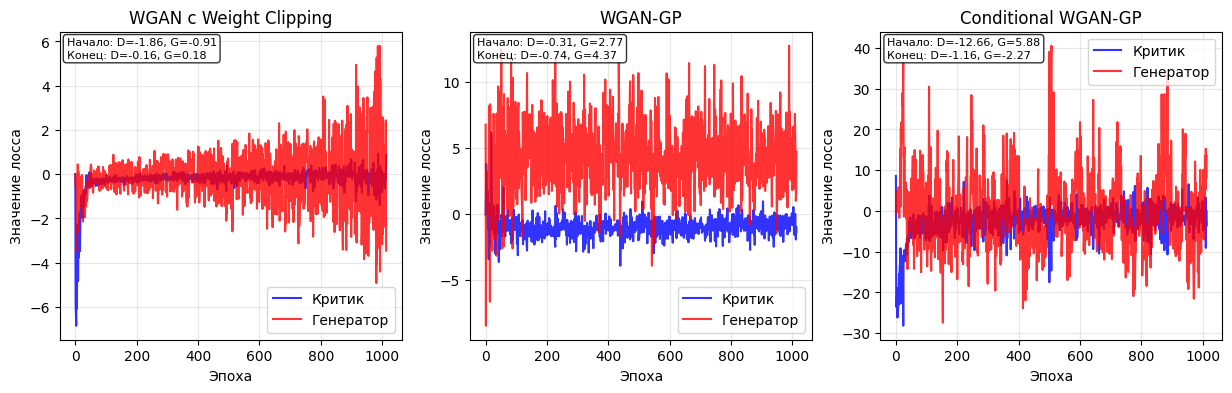

In [31]:
import matplotlib.pyplot as plt
import numpy as np

experiments_data = []

experiments = [
    ("WGAN с Weight Clipping", "losses_D_clip", "losses_G_clip"),
    ("WGAN-GP", "losses_D_gp", "losses_G_gp"),
    ("Conditional WGAN-GP", "losses_D_cond", "losses_G_cond")
]

for exp_name, D_var, G_var in experiments:
    if D_var in globals() and G_var in globals():
        D_data = globals()[D_var]
        G_data = globals()[G_var]

        if len(D_data) > 0 and len(G_data) > 0:
            experiments_data.append((exp_name, D_data, G_data))
            print(f"{exp_name}: {len(D_data)} итераций")

if len(experiments_data) == 0:
    print("Нет данных для анализа")
    exit()

print(f"Всего экспериментов: {len(experiments_data)}")



print("Графики обучения")



fig, axes = plt.subplots(1, len(experiments_data), figsize=(5*len(experiments_data), 4))

if len(experiments_data) == 1:
    axes = [axes]

for idx, (exp_name, D_data, G_data) in enumerate(experiments_data):
    ax = axes[idx]


    if hasattr(D_data[0], 'item'):
        D_data = [d.item() for d in D_data]
        G_data = [g.item() for g in G_data]


    max_points = 1000
    if len(D_data) > max_points:
        step = len(D_data) // max_points
        D_data = D_data[::step]
        G_data = G_data[::step]


    iterations = range(len(D_data))
    ax.plot(iterations, D_data, label='Критик', linewidth=1.5, alpha=0.8, color='blue')
    ax.plot(iterations, G_data, label='Генератор', linewidth=1.5, alpha=0.8, color='red')


    ax.set_title(f'{exp_name}')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel('Значение лосса')
    ax.legend()
    ax.grid(True, alpha=0.3)


    start_D = np.mean(D_data[:50]) if len(D_data) > 50 else D_data[0]
    end_D = np.mean(D_data[-50:]) if len(D_data) > 50 else D_data[-1]
    start_G = np.mean(G_data[:50]) if len(G_data) > 50 else G_data[0]
    end_G = np.mean(G_data[-50:]) if len(G_data) > 50 else G_data[-1]

    info_text = (f'Начало: D={start_D:.2f}, G={start_G:.2f}\n'
                 f'Конец: D={end_D:.2f}, G={end_G:.2f}')

    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))



## Итоги
1) Во всех эксперементах прослеживается дисбаланс между лоссами гениратора и дескриминатора
2) Гиперпараметры почти не варьировал , можно было бы попробовать поиграть с ними и посмотреть улучшения
3) Критик обучается быстрее генератора

**Что можно было бы улучшить**
1) Поиграться с гиперпараметрами
2) Изменить архитектуру сетей
3) Посмотреть метрики качества